In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,iplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LogisticRegression
from catboost import Pool, CatBoostClassifier, cv
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import average_precision_score,classification_report
from sklearn.ensemble import RandomForestClassifier
import optuna
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

C:\Users\araga\AppData\Local\Temp\ipykernel_12952\888196002.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#combining all tdcsfog '.csv' train files
tdcsfog_path= r'C:\Users\araga\.vscode\FoG Project (AI Scholars)\tlvmc-parkinsons-freezing-gait-prediction\train\tdcsfog'
tdcsfog_list= []

for file_name in os.listdir(tdcsfog_path):
    if file_name.endswith('.csv'):
        file_path= os.path.join(tdcsfog_path,file_name)
        df= pd.read_csv(file_path)
        df['Time']= df['Time']/(len(df)-1) 
        tdcsfog_list.append(df)
     
tdcsfog = pd.concat(tdcsfog_list,axis= 0)
tdcsfog

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,0.000000,-9.533939,0.566322,-1.413525,0,0,0
1,0.000214,-9.536140,0.564137,-1.440621,0,0,0
2,0.000427,-9.529345,0.561765,-1.429332,0,0,0
3,0.000641,-9.531239,0.564227,-1.415490,0,0,0
4,0.000855,-9.540825,0.561854,-1.429471,0,0,0
...,...,...,...,...,...,...,...
4220,0.999053,-9.403467,0.089003,-3.220304,0,0,0
4221,0.999290,-9.404246,0.090531,-3.216584,0,0,0
4222,0.999527,-9.405770,0.084380,-3.224039,0,0,0
4223,0.999763,-9.403579,0.084236,-3.236686,0,0,0


In [3]:
defog_path = r'C:\Users\araga\.vscode\FoG Project (AI Scholars)\tlvmc-parkinsons-freezing-gait-prediction\train\defog'

defog_list = []

for file_name in os.listdir(defog_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(defog_path, file_name)
        file = pd.read_csv(file_path)
        file.Time = file.Time / (len(file) - 1)
        defog_list.append(file)

defog = pd.concat(defog_list, axis = 0)

defog.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0.000000,-1.0,0.044129,-0.25,0,0,0,False,False
1,0.000006,-1.0,0.034431,-0.25,0,0,0,False,False
2,0.000012,-1.0,0.031250,-0.25,0,0,0,False,False
3,0.000018,-1.0,0.031250,-0.25,0,0,0,False,False
4,0.000025,-1.0,0.031250,-0.25,0,0,0,False,False


In [4]:
print(defog.columns)
print(tdcsfog.columns)

defog= defog[(defog['Valid']==1) & (defog['Task']==1)]
defog.dropna()

Index(['Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Walking',
       'Valid', 'Task'],
      dtype='object')
Index(['Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Walking'], dtype='object')


,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
1000,0.006139,-0.970018,0.061626,-0.265625,0,0,0,True,True
1001,0.006145,-0.984375,0.044497,-0.265625,0,0,0,True,True
1002,0.006151,-0.984375,0.029016,-0.265625,0,0,0,True,True
1003,0.006157,-0.984375,0.015625,-0.265625,0,0,0,True,True
1004,0.006163,-0.984670,0.015330,-0.265625,0,0,0,True,True
...,...,...,...,...,...,...,...,...,...
119027,0.991635,-0.961216,0.142428,-0.289655,0,0,0,True,True
119028,0.991644,-0.960343,0.142836,-0.290506,0,0,0,True,True
119029,0.991652,-0.957958,0.145494,-0.290007,0,0,0,True,True
119030,0.991660,-0.960616,0.145839,-0.291527,0,0,0,True,True


In [5]:
defog= defog.iloc[:,:7]

In [6]:
merged= pd.concat([tdcsfog,defog],axis=0)
merged

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,0.000000,-9.533939,0.566322,-1.413525,0,0,0
1,0.000214,-9.536140,0.564137,-1.440621,0,0,0
2,0.000427,-9.529345,0.561765,-1.429332,0,0,0
3,0.000641,-9.531239,0.564227,-1.415490,0,0,0
4,0.000855,-9.540825,0.561854,-1.429471,0,0,0
...,...,...,...,...,...,...,...
119027,0.991635,-0.961216,0.142428,-0.289655,0,0,0
119028,0.991644,-0.960343,0.142836,-0.290506,0,0,0
119029,0.991652,-0.957958,0.145494,-0.290007,0,0,0
119030,0.991660,-0.960616,0.145839,-0.291527,0,0,0


Exploratory Data Analysis

<Axes: >

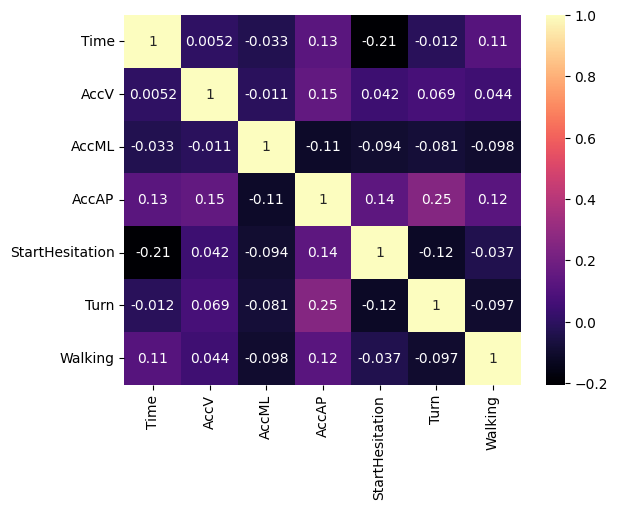

In [7]:
sns.heatmap(tdcsfog.corr(),annot= True,cmap='magma')

<Axes: xlabel='Number of 1s', ylabel='count'>

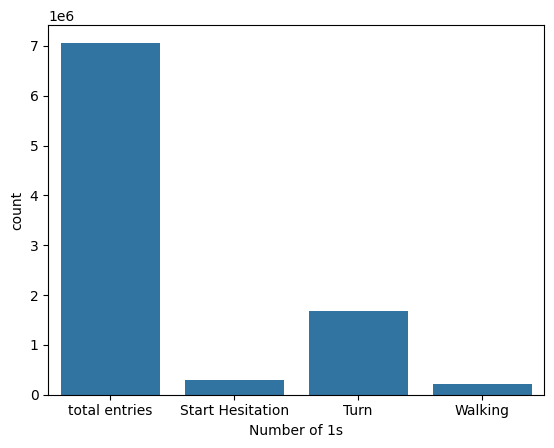

In [8]:
df2= pd.DataFrame(np.concatenate([
    ['total entries'] * len(tdcsfog),
    ['Start Hesitation'] *  int(tdcsfog['StartHesitation'].mean() * len(tdcsfog)),
    ['Turn'] * int(tdcsfog['Turn'].mean() * len(tdcsfog)),
    ['Walking'] * int(tdcsfog['Walking'].mean() * len(tdcsfog))]),
    columns= ['Number of 1s']              
    )

sns.countplot(data= df2, x='Number of 1s')

In [9]:
#fog_data = pd.read_csv(r'C:\Users\araga\.vscode\FoG Project (AI Scholars)\tlvmc-parkinsons-freezing-gait-prediction\train\tdcsfog/08d6702e8a.csv')

#sns.pairplot(tdcsfog[['AccV','AccML','AccAP', "Time"]])

In [10]:


# sns.histplot(fog_data['AccV'])

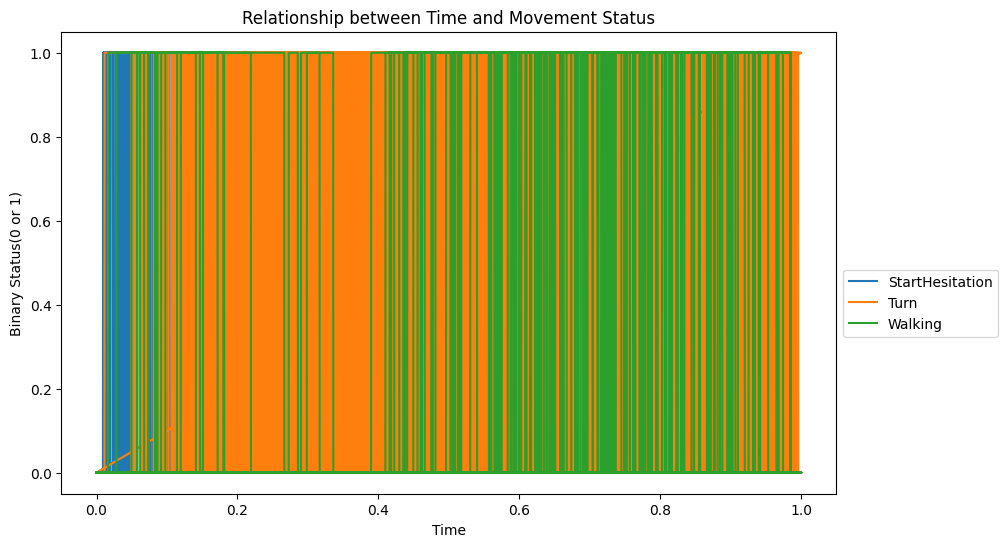

In [11]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(tdcsfog['Time'], tdcsfog['StartHesitation'], label = 'StartHesitation')
ax.plot(tdcsfog['Time'], tdcsfog['Turn'], label = 'Turn')
ax.plot(tdcsfog['Time'], tdcsfog['Walking'], label = 'Walking')

ax.set_xlabel('Time')
ax.set_ylabel('Binary Status(0 or 1)')
ax.set_title('Relationship between Time and Movement Status')

ax.legend(loc='upper left',bbox_to_anchor=(1,0.5))

Data Preparation

In [12]:
X_merged = merged.iloc[:,0:4]  
X = tdcsfog.iloc[:,0:4]  
y1 = merged['StartHesitation']  # target variable for StartHesitation
y2 = merged['Turn']  # target variable for Turn
y3 = tdcsfog['Walking']  # target variable for Walking
print(X_merged.head(), "\n")
print(y2.head())
print (X_merged.shape)
print (y2.shape)

       Time      AccV     AccML     AccAP
0  0.000000 -9.533939  0.566322 -1.413525
1  0.000214 -9.536140  0.564137 -1.440621
2  0.000427 -9.529345  0.561765 -1.429332
3  0.000641 -9.531239  0.564227 -1.415490
4  0.000855 -9.540825  0.561854 -1.429471 

0    0
1    0
2    0
3    0
4    0
Name: Turn, dtype: int64
(11153202, 4)
(11153202,)


In [13]:
y1_ones= np.where(y1==1)[0] #indices of ones
np.random.seed(10)
n1_ones= (y1==1).sum() #total of ones
y1_zeros= np.random.choice(np.where(y1==0)[0],size= n1_ones,replace= False) # chose same n1_ones from indices of zeros

y1_balanced_idx= np.sort(np.concatenate([y1_zeros,y1_ones]))
y1_balanced_idx

array([      18,       55,       84, ..., 11153127, 11153164, 11153182],
      dtype=int64)

In [14]:
X1_balanced= X_merged.iloc[y1_balanced_idx,:]
y1_balanced= y1.iloc[y1_balanced_idx]
X1_balanced.shape

(610580, 4)

In [15]:
y2_ones= np.where(y2==1)[0]
np.random.seed(10)

n2_ones= (y2==1).sum()
y2_zeros= np.random.choice(np.where(y2==0)[0],size= n2_ones,replace= False)

y2_balanced_idx= np.sort(np.concatenate([y2_zeros,y2_ones]))

X2_balanced= X_merged.iloc[y2_balanced_idx,:]
y2_balanced= y2.iloc[y2_balanced_idx]

In [16]:
y3_ones= np.where(y3==1)[0]
np.random.seed(10)

n3_ones= (y3==1).sum()
y3_zeros= np.random.choice(np.where(y3==0)[0],size= n3_ones,replace= False)

y3_balanced_idx= np.sort(np.concatenate([y3_zeros,y3_ones]))

X3_balanced= X.iloc[y3_balanced_idx,:]
y3_balanced= y3.iloc[y3_balanced_idx]

In [17]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X_merged, y2, test_size = 0.2, random_state = 42)
print(X2_train.shape)
print(X2_test.shape)

print(y2_train.shape)
print(y2_test.shape)



(8922561, 4)
(2230641, 4)
(8922561,)
(2230641,)




Epoch 1/20


55766/55766 [==============================] - 135s 2ms/step - loss: 0.4004 - accuracy: 0.8153 - val_loss: 0.3848 - val_accuracy: 0.8196
Epoch 2/20
55766/55766 [==============================] - 134s 2ms/step - loss: 0.3852 - accuracy: 0.8206 - val_loss: 0.3799 - val_accuracy: 0.8232
Epoch 3/20
55766/55766 [==============================] - 133s 2ms/step - loss: 0.3814 - accuracy: 0.8226 - val_loss: 0.3767 - val_accuracy: 0.8248
Epoch 4/20
55766/55766 [==============================] - 133s 2ms/step - loss: 0.3789 - accuracy: 0.8238 - val_loss: 0.3759 - val_accuracy: 0.8264
Epoch 5/20
55766/55766 [==============================] - 153s 3ms/step - loss: 0.3766 - accuracy: 0.8253 - val_loss: 0.3727 - val_accuracy: 0.8270
Epoch 6/20
55766/55766 [==============================] - 149s 3ms/step - loss: 0.3746 - accuracy: 0.8268 - val_loss: 0.3729 - val_accuracy: 0.8281
Epoch 7/20
55766/55766 [==============================] - 153s 3ms/step - loss: 0.3730 - accuracy: 0.8276 - 

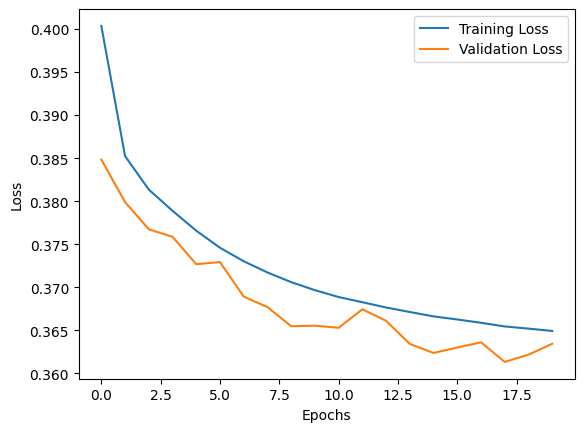

69708/69708 [==============================] - 69s 990us/step
Accuracy on Test Set: 0.8332017568044342
Precision on Test Set: 0.6798941450633945
Recall on Test Set: 0.3411974064416097
F1 Score on Test Set: 0.4543728103685693


In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

# Normalize the input data
scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

# Reshape the data for GRU
X2_train_reshaped = X2_train_scaled.reshape((X2_train_scaled.shape[0], X2_train_scaled.shape[1], 1))
X2_test_reshaped = X2_test_scaled.reshape((X2_test_scaled.shape[0], X2_test_scaled.shape[1], 1))

# Define the GRU model
model_gru = Sequential()
model_gru.add(GRU(64, activation='relu', input_shape=(X2_train_reshaped.shape[1], X2_train_reshaped.shape[2]))) #change 64--> 128
model_gru.add(Dropout(0.2)) # reduce dropout (mainly for overfitting) <-- maybe remove entirely??
model_gru.add(Dense(32, activation='relu'))
model_gru.add(Dense(1, activation='sigmoid'))
#add dense layers
#try adding 1 more gru layer

# Compile the model
model_gru.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy']) #continue adjusting learning rate

# Train the model
history = model_gru.fit(X2_train_reshaped, y2_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[EarlyStopping(patience=3)]) #consider adding epochs

# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions
y2_test_pred_proba = model_gru.predict(X2_test_reshaped)
y2_test_pred_binary = (y2_test_pred_proba > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y2_test, y2_test_pred_binary)
precision = precision_score(y2_test, y2_test_pred_binary)
recall = recall_score(y2_test, y2_test_pred_binary)
f1 = f1_score(y2_test, y2_test_pred_binary)

print(f"Accuracy on Test Set: {accuracy}")
print(f"Precision on Test Set: {precision}")
print(f"Recall on Test Set: {recall}")
print(f"F1 Score on Test Set: {f1}")


In [1]:
#combining all tdcsfog '.csv' train files
tdcsfog_path= r'C:\Users\araga\.vscode\FoG Project (AI Scholars)\tlvmc-parkinsons-freezing-gait-prediction\train\tdcsfog\fd52a32229.csv'
fog_data = pd.read_csv(tdcsfog_path)

fog_data= fog_data[(fog_data['Valid']==1) & (fog_data['Task']==1)]
fog_data.dropna()
data = fog_data.to_numpy()
data_reshaped = scaler.transform(data)

processed_fog_data = data_reshaped.reshape((data_reshaped.shape[0], data_reshaped.shape[1], 1))

predictions = model_gru.predict(processed_fog_data)

plt.scatter(fog_data['Time'], fog_data['AccML'], s=2, c=predictions, alpha=0.5)
plt.xlabel('Time')  # Add x-axis label
plt.ylabel('AccML')  # Add y-axis label
plt.show()

NameError: name 'pd' is not defined

In [36]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Assuming X2_train, X2_test, y2_train, y2_test are your training and testing data
X2_train, X2_test, y2_train, y2_test = train_test_split(X_merged, y2, test_size=0.2, random_state=42)

# Convert DataFrame to NumPy array
X2_train_array = X2_train.to_numpy()
X2_test_array = X2_test.to_numpy()

# Reshape the data for LSTM (assuming each row is a timestamp)
X2_train_reshaped = X2_train_array.reshape((X2_train_array.shape[0], 1, X2_train_array.shape[1]))
X2_test_reshaped = X2_test_array.reshape((X2_test_array.shape[0], 1, X2_test_array.shape[1]))

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='relu', input_shape=(X2_train_reshaped.shape[1], X2_train_reshaped.shape[2])))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_lstm.fit(X2_train_reshaped, y2_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[EarlyStopping(patience=3)])


Epoch 1/10


55766/55766 [==============================] - 237s 4ms/step - loss: 0.4184 - accuracy: 0.8084 - val_loss: 0.4070 - val_accuracy: 0.8127
Epoch 2/10
55766/55766 [==============================] - 238s 4ms/step - loss: 0.4078 - accuracy: 0.8107 - val_loss: 0.4062 - val_accuracy: 0.8139
Epoch 3/10
55766/55766 [==============================] - 248s 4ms/step - loss: 0.4041 - accuracy: 0.8120 - val_loss: 0.4005 - val_accuracy: 0.8148
Epoch 4/10
55766/55766 [==============================] - 241s 4ms/step - loss: 0.4018 - accuracy: 0.8129 - val_loss: 0.3998 - val_accuracy: 0.8143
Epoch 5/10
55766/55766 [==============================] - 235s 4ms/step - loss: 0.3999 - accuracy: 0.8138 - val_loss: 0.3983 - val_accuracy: 0.8138
Epoch 6/10
55766/55766 [==============================] - 203s 4ms/step - loss: 0.3985 - accuracy: 0.8146 - val_loss: 0.3972 - val_accuracy: 0.8163
Epoch 7/10
55766/55766 [==============================] - 207s 4ms/step - loss: 0.3972 - accuracy: 0.8150 - va

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch

# Assuming X2_train, X2_test, y2_train, y2_test are your training and testing data
X2_train, X2_test, y2_train, y2_test = train_test_split(X_merged, y2, test_size=0.2, random_state=42)

# Convert DataFrame to NumPy array
X2_train_array = X2_train.to_numpy()
X2_test_array = X2_test.to_numpy()

# Reshape the data for LSTM (assuming each row is a timestamp)
X2_train_reshaped = X2_train_array.reshape((X2_train_array.shape[0], 1, X2_train_array.shape[1]))
X2_test_reshaped = X2_test_array.reshape((X2_test_array.shape[0], 1, X2_test_array.shape[1]))

# Define the model-building function
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), activation='relu', input_shape=(X2_train_reshaped.shape[1], X2_train_reshaped.shape[2])))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # You can adjust the number of trials
    directory='keras_tuner_dir',
    project_name='lstm_tuning'
)

# Search for the best hyperparameters
tuner.search(X2_train_reshaped, y2_train, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(patience=3)])

# Get the best hyperparameters
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print(f"Best Hyperparameters: {best_hps}")

# Build the model with the best hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model
history = best_model.fit(X2_train_reshaped, y2_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[EarlyStopping(patience=3)])




Trial 5 Complete [01h 08m 40s]
val_accuracy: 0.8235059380531311

Best val_accuracy So Far: 0.8298129439353943
Total elapsed time: 06h 38m 21s
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x0000020EBD7ED610>

Epoch 1/20
55766/55766 [==============================] - 164s 3ms/step - loss: 0.3740 - accuracy: 0.8282 - val_loss: 0.3707 - val_accuracy: 0.8306
Epoch 2/20
55766/55766 [==============================] - 162s 3ms/step - loss: 0.3734 - accuracy: 0.8286 - val_loss: 0.3687 - val_accuracy: 0.8316
Epoch 3/20
55766/55766 [==============================] - 162s 3ms/step - loss: 0.3731 - accuracy: 0.8287 - val_loss: 0.3688 - val_accuracy: 0.8313
Epoch 4/20
55766/55766 [==============================] - 162s 3ms/step - loss: 0.3729 - accuracy: 0.8287 - val_loss: 0.3693 - val_accuracy: 0.8314
Epoch 5/20
55766/55766 [==============================] - 162s 3ms/step - loss: 0.3725 - accuracy: 0.8290 - val_loss: 0.3690 - val_accuracy: 

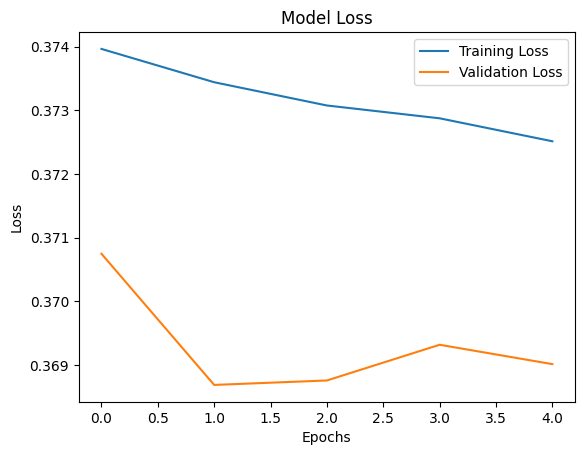

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [21]:
# Plot loss during training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test set
y_pred = best_model.predict_classes(X2_test_reshaped)

# Calculate metrics
accuracy = accuracy_score(y2_test, y_pred)
precision = precision_score(y2_test, y_pred)
recall = recall_score(y2_test, y_pred)
f1 = f1_score(y2_test, y_pred)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Print confusion matrix
conf_matrix = confusion_matrix(y2_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)




GRU

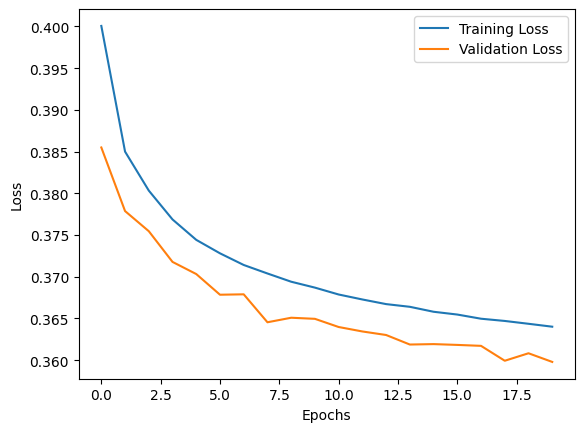

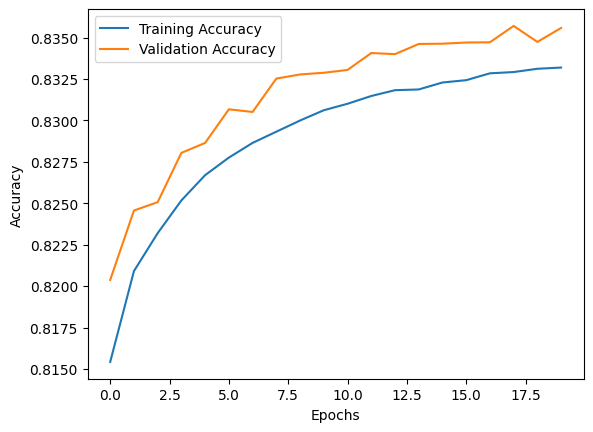

In [24]:
# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

LIGHT GBM
